In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx

In [2]:
datadir = './kleinlab/'

In [3]:
df_metadata = pd.read_csv(os.path.join(datadir,'metadata.tsv.gz'),sep='\t',index_col=0)
print(df_metadata.shape)
df_metadata.head()

(3221, 4)


,time,Population,Annotation,Well
84,6.0,LK,Mast,2
115,6.0,LK,Monocyte,2
190,6.0,LK,Mast,2
205,6.0,LK,Mast,2
337,6.0,LK,Meg,2


In [4]:
df_coord = pd.read_csv(os.path.join(datadir,'coordinates.tsv.gz'),sep='\t',index_col=0)
print(df_coord.shape)
df_coord.head()

(3221, 2)


,0,1
84,-1674.817,-867.362
115,2970.137,390.955
190,-1667.094,-846.103
205,-1769.354,-902.560
337,-1866.029,739.786


In [5]:
df_clones = pd.read_csv(os.path.join(datadir,'clones.tsv.gz'),sep='\t',index_col=0)
print(df_clones.shape)
df_clones.head()
### remove clones that have zero cells
df_clones = df_clones[df_clones.columns[df_clones.sum(axis=0)>0]]
print(df_clones.shape)
df_clones.head()

(3221, 5864)
(3221, 365)


,50,82,105,111,134,190,213,239,251,269,...,5744,5764,5772,5773,5774,5805,5806,5818,5832,5850
84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
all(df_clones.sum(axis=1)==1)

True

In [7]:
with open(os.path.join(datadir,'list_dist.pkl'), 'rb') as f:
    list_dist = pickle.load(f)

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics.cluster import adjusted_rand_score

In [9]:
Z = linkage(list_dist, 'ward')
# clone_clusters = fcluster(Z, 5000, criterion='distance')
clone_clusters = fcluster(Z, 5, criterion='maxclust')

In [10]:
### read in groundtruth file
df_truth = pd.read_csv(os.path.join(datadir,'./clones_truth.tsv.gz'),sep='\t',index_col=0)
### score the result
adjusted_rand_score(df_truth['celltype'].tolist(), clone_clusters.tolist())

0.802824918977734

In [11]:
clone_clusters = pd.Series(index=df_clones.columns,data=clone_clusters)

In [12]:
df_input = pd.merge(df_metadata,df_coord,left_index=True,right_index=True)
df_input['clone'] = df_clones.columns[np.where(df_clones>0)[1]]
df_input['clone_cluster'] = [str(clone_clusters[x]) for x in df_input['clone']]

In [13]:
df_input.head()

,time,Population,Annotation,Well,0,1,clone,clone_cluster
84,6.0,LK,Mast,2,-1674.817,-867.362,2397,2
115,6.0,LK,Monocyte,2,2970.137,390.955,2187,3
190,6.0,LK,Mast,2,-1667.094,-846.103,3151,2
205,6.0,LK,Mast,2,-1769.354,-902.560,3151,2
337,6.0,LK,Meg,2,-1866.029,739.786,2217,2


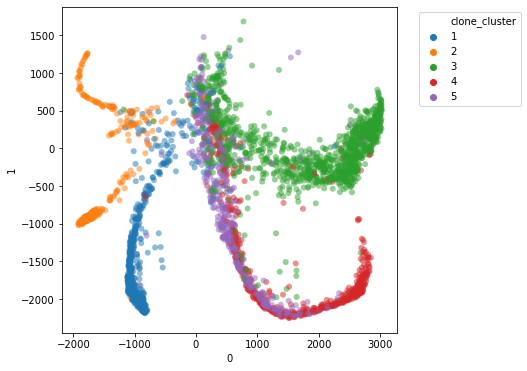

In [14]:
plt.figure(figsize=(6,6))
ax = sns.scatterplot(x='0', y='1',hue='clone_cluster', data=df_input,linewidth=0,alpha=0.5,
                    palette=sns.color_palette(n_colors=len(df_input['clone_cluster'].unique())))
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))

In [15]:
import elpigraph
import itertools
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.spatial import distance,cKDTree

In [16]:
dict_epg = dict()
for i in np.unique(df_input['clone_cluster']):
    cl_i = df_input[df_input.clone_cluster==i][['0','1']].values
    epg_i = elpigraph.computeElasticPrincipalTree(X = cl_i,
                                                  NumNodes = 30,
                                                  n_cores = 1,
                                                  Do_PCA=False,CenterData=False,
                                                  Lambda=0.07,Mu=0.001,alpha=0.1,
                                                  TrimmingRadius=500
                                                  )
#     epg_i = elpigraph.computeElasticPrincipalCurve(X = cl_i,
#                                                     NumNodes = 20,
#                                                     n_cores = 1,
#                                                     drawAccuracyComplexity = False, drawEnergy = False,drawPCAView = False,
#                                                     Do_PCA=False,CenterData=False,
#                                                     alpha=2,TrimmingRadius=500)    
    dict_epg[i] = epg_i

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  612  points and  2  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	45374.0217	30	29	28	0	0	0	24665.611	inf	0.9725	-inf	20696.9357	11.475	344.2509	10327.5277	0


1.2802  seconds elapsed
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  294  points and  2  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

In [17]:
epg_color_palette = sns.color_palette(n_colors=len(df_input['clone_cluster'].unique()))
dict_epg_color = {x: epg_color_palette[i-1] for i,x in enumerate(dict_epg.keys())}

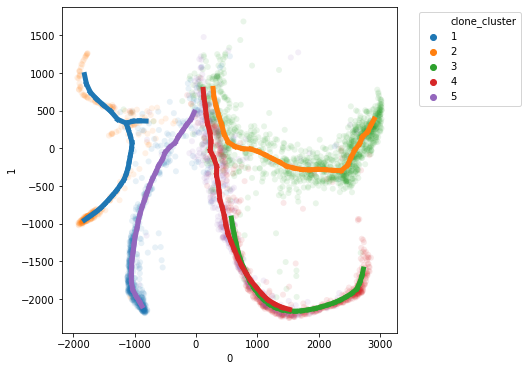

In [18]:
plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="0", y="1",hue='clone_cluster', data=df_input,linewidth=0,alpha=0.1,
                    palette=sns.color_palette(n_colors=len(df_input['clone_cluster'].unique())))
for i in dict_epg.keys():
    epg_i = dict_epg[i]
    for ii in range(epg_i[0]['Edges'][0].shape[0]):
        edge_ii = epg_i[0]['Edges'][0][ii]
        nodes_pos_ii = epg_i[0]['NodePositions'][edge_ii,:]
        plt.plot(nodes_pos_ii[:,0],nodes_pos_ii[:,1],
                 color=dict_epg_color[i],
                 linewidth=5)

plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))

### pseudotime inference

In [19]:
def extract_branches(epg):
    #record the original degree(before removing nodes) for each node
    degrees_of_nodes = epg.degree()
    epg_copy = epg.copy()
    dict_branches = dict()
    clusters_to_merge=[]
    while epg_copy.order()>1: #the number of vertices
        leaves=[n for n,d in epg_copy.degree() if d==1]
        nodes_included=list(epg_copy.nodes())
        while leaves:
            leave=leaves.pop()
            nodes_included.remove(leave)
            nodes_to_merge=[leave]
            nodes_to_visit=list(epg_copy.nodes())
            dfs_from_leaf(epg_copy,leave,degrees_of_nodes,nodes_to_visit,nodes_to_merge)
            clusters_to_merge.append(nodes_to_merge)
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])] = {}
            dict_branches[(nodes_to_merge[0],nodes_to_merge[-1])]['nodes'] = nodes_to_merge
            nodes_to_delete = nodes_to_merge[0:len(nodes_to_merge)-1]
            if epg_copy.degree()[nodes_to_merge[-1]] == 1: #avoid the single point
                nodes_to_delete = nodes_to_merge
                leaves = []
            epg_copy.remove_nodes_from(nodes_to_delete)
    dict_branches = add_branch_info(epg,dict_branches)
    # print('Number of branches: ' + str(len(clusters_to_merge)))
    return dict_branches

def construct_flat_tree(dict_branches):
    flat_tree = nx.Graph()
    flat_tree.add_nodes_from(list(set(itertools.chain.from_iterable(dict_branches.keys()))))
    flat_tree.add_edges_from(dict_branches.keys())
    root = list(flat_tree.nodes())[0]
    edges = nx.bfs_edges(flat_tree, root)
    nodes = [root] + [v for u, v in edges]  
    dict_nodes_label = dict()
    for i,node in enumerate(nodes):
        dict_nodes_label[node] = 'S'+str(i) 
    nx.set_node_attributes(flat_tree,values=dict_nodes_label,name='label')
    dict_branches_color = dict()
    dict_branches_len = dict()
    dict_branches_nodes = dict()
    dict_branches_id = dict() #the direction of nodes for each edge
    for x in dict_branches.keys():
        dict_branches_color[x]=dict_branches[x]['color']
        dict_branches_len[x]=dict_branches[x]['len']
        dict_branches_nodes[x]=dict_branches[x]['nodes']
        dict_branches_id[x]=dict_branches[x]['id'] 
    nx.set_edge_attributes(flat_tree,values=dict_branches_nodes,name='nodes')
    nx.set_edge_attributes(flat_tree,values=dict_branches_id,name='id')
    nx.set_edge_attributes(flat_tree,values=dict_branches_color,name='color')
    nx.set_edge_attributes(flat_tree,values=dict_branches_len,name='len')    
    return flat_tree

def dfs_from_leaf(epg_copy,node,degrees_of_nodes,nodes_to_visit,nodes_to_merge):
    nodes_to_visit.remove(node)
    for n2 in epg_copy.neighbors(node):
        if n2 in nodes_to_visit:
            if degrees_of_nodes[n2]==2:  #grow the branch
                if n2 not in nodes_to_merge:
                    nodes_to_merge.append(n2)
                dfs_from_leaf(epg_copy,n2,degrees_of_nodes,nodes_to_visit,nodes_to_merge)
            else:
                nodes_to_merge.append(n2)
                return
def project_point_to_line_segment_matrix(XP,p):
    XP = np.array(XP,dtype=float)
    p = np.array(p,dtype=float)
    AA=XP[:-1,:]
    BB=XP[1:,:]
    AB = (BB-AA)
    AB_squared = (AB*AB).sum(1)
    Ap = (p-AA)
    t = (Ap*AB).sum(1)/AB_squared
    t[AB_squared == 0]=0
    Q = AA + AB*np.tile(t,(XP.shape[1],1)).T
    Q[t<=0,:]=AA[t<=0,:]
    Q[t>=1,:]=BB[t>=1,:]
    kdtree=cKDTree(Q)
    d,idx_q=kdtree.query(p)
    dist_p_to_q = np.sqrt(np.inner(p-Q[idx_q,:],p-Q[idx_q,:]))
    XP_p = np.row_stack((XP[:idx_q+1],Q[idx_q,:]))
    lam = np.sum(np.sqrt(np.square((XP_p[1:,:] - XP_p[:-1,:])).sum(1)))
    return list([Q[idx_q,:],idx_q,dist_p_to_q,lam])
            
def add_branch_info(epg,dict_branches):
    dict_nodes_pos = nx.get_node_attributes(epg,'pos')
    sns_palette = sns.color_palette("hls", len(dict_branches)).as_hex()
    if(dict_nodes_pos != {}):
        for i,(br_key,br_value) in enumerate(dict_branches.items()):
            nodes = br_value['nodes']
            dict_branches[br_key]['id'] = (nodes[0],nodes[-1]) #the direction of nodes for each branch
            br_nodes_pos = np.array([dict_nodes_pos[i] for i in nodes]) 
            dict_branches[br_key]['len'] = sum(np.sqrt(((br_nodes_pos[0:-1,:] - br_nodes_pos[1:,:])**2).sum(1)))
            dict_branches[br_key]['color'] = sns_palette[i]
    return dict_branches

def project_cells_to_epg(cells,flat_tree,epg):
    input_data = cells[['0','1']].values
    dict_nodes_pos = nx.get_node_attributes(epg,'pos')
    nodes_pos = np.empty((0,input_data.shape[1]))
    nodes = np.empty((0,1),dtype=int)
    for key in dict_nodes_pos.keys():
        nodes_pos = np.vstack((nodes_pos,dict_nodes_pos[key]))
        nodes = np.append(nodes,key)    
    indices = pairwise_distances_argmin_min(input_data,nodes_pos,axis=1,metric='euclidean')[0]
    x_node = nodes[indices]
    
    dict_branches_nodes = nx.get_edge_attributes(flat_tree,'nodes')
    dict_branches_id = nx.get_edge_attributes(flat_tree,'id')
    dict_node_state = nx.get_node_attributes(flat_tree,'label')
    list_x_br_id = list()
    list_x_br_id_alias = list()
    list_x_lam = list()
    list_x_dist = list()
    for ix,xp in enumerate(input_data): 
        list_br_id = [flat_tree.edges[br_key]['id'] for br_key,br_value in dict_branches_nodes.items() if x_node[ix] in br_value]
        dict_br_matrix = dict()
        for br_id in list_br_id:
            dict_br_matrix[br_id] = np.array([dict_nodes_pos[i] for i in flat_tree.edges[br_id]['nodes']])            
        dict_results = dict()
        list_dist_xp = list()
        for br_id in list_br_id:
            dict_results[br_id] = project_point_to_line_segment_matrix(dict_br_matrix[br_id],xp)
            list_dist_xp.append(dict_results[br_id][2])
        x_br_id = list_br_id[np.argmin(list_dist_xp)]
        x_br_id_alias = dict_node_state[x_br_id[0]],dict_node_state[x_br_id[1]]
        br_len = flat_tree.edges[x_br_id]['len']
        results = dict_results[x_br_id]
        x_dist = results[2]
        x_lam = results[3]
        if(x_lam>br_len):
            x_lam = br_len 
        list_x_br_id.append(x_br_id)
        list_x_br_id_alias.append(x_br_id_alias)
        list_x_lam.append(x_lam)
        list_x_dist.append(x_dist)
    cells['branch_id'] = list_x_br_id
    cells['branch_id_alias'] = list_x_br_id_alias
#     adata.uns['branch_id'] = list(set(adata.obs['branch_id'].tolist()))
    cells['branch_lam'] = list_x_lam
    cells['branch_dist'] = list_x_dist
    return cells

def calculate_pseudotime(cells,flat_tree):
    dict_edge_len = nx.get_edge_attributes(flat_tree,'len')
    # dict_nodes_pseudotime = dict()
    for root_node in flat_tree.nodes():
        df_pseudotime = pd.Series(index=df_coord.index)
        list_bfs_edges = list(nx.bfs_edges(flat_tree,source=root_node))
        dict_bfs_predecessors = dict(nx.bfs_predecessors(flat_tree,source=root_node))
        for edge in list_bfs_edges:
            list_pre_edges = list()
            pre_node = edge[0]
            while(pre_node in dict_bfs_predecessors.keys()):
                pre_edge = (dict_bfs_predecessors[pre_node],pre_node)
                list_pre_edges.append(pre_edge)
                pre_node = dict_bfs_predecessors[pre_node]
            len_pre_edges = sum([flat_tree.edges[x]['len'] for x in list_pre_edges]) 
            indices = cells[(cells['branch_id'] == edge) | (cells['branch_id'] == (edge[1],edge[0]))].index
            if(edge==flat_tree.edges[edge]['id']):
                df_pseudotime[indices] = len_pre_edges + cells.loc[indices,'branch_lam']
            else:
                df_pseudotime[indices] = len_pre_edges + (flat_tree.edges[edge]['len']-cells.loc[indices,'branch_lam'])
        cells[flat_tree.nodes[root_node]['label']+'_pseudotime'] = df_pseudotime
    return cells

In [20]:
def get_pseudotime(cells_i,epg_i):
    epg_nodes_pos = epg_i[0]['NodePositions']
    epg_edges = epg_i[0]['Edges'][0]    
    
    epg=nx.Graph()
    epg.add_nodes_from(range(epg_nodes_pos.shape[0]))
    epg.add_edges_from(epg_edges)
    dict_nodes_pos = {i:x for i,x in enumerate(epg_nodes_pos)}
    nx.set_node_attributes(epg,values=dict_nodes_pos,name='pos')
    dict_branches = extract_branches(epg)
    flat_tree = construct_flat_tree(dict_branches)
    nx.set_node_attributes(flat_tree,values={x:dict_nodes_pos[x] for x in flat_tree.nodes()},name='pos')

    cells_i = project_cells_to_epg(cells_i,flat_tree,epg)
    cells_i = calculate_pseudotime(cells_i,flat_tree)
    return(cells_i)

In [21]:
dict_pseudotime = dict()
for x in dict_epg.keys():
    epg_i = dict_epg[x]
    cells_i = df_input[df_input.clone_cluster==x]
    dict_pseudotime[x] = get_pseudotime(cells_i,epg_i)

/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [23]:
### choose clone cluster '3' as an example
cells_i = dict_pseudotime['3']

In [24]:
cells_i.head()

,time,Population,Annotation,Well,0,1,clone,clone_cluster,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S1_pseudotime
115,6.0,LK,Monocyte,2,2970.137,390.955,2187,3,"(29, 27)","(S1, S0)",3551.119732,65.250836,0.000000,3551.119732
492,6.0,LK,Monocyte,2,2633.238,490.960,333,3,"(29, 27)","(S1, S0)",3484.970434,283.089403,66.149298,3484.970434
644,6.0,LK,Monocyte,2,2694.283,-107.561,1861,3,"(29, 27)","(S1, S0)",3011.877868,135.027767,539.241864,3011.877868
737,6.0,LK,Monocyte,2,2992.282,355.772,4117,3,"(29, 27)","(S1, S0)",3551.119732,92.942567,0.000000,3551.119732
1090,6.0,LK,Monocyte,2,2931.359,297.769,3696,3,"(29, 27)","(S1, S0)",3491.340303,72.098319,59.779429,3491.340303


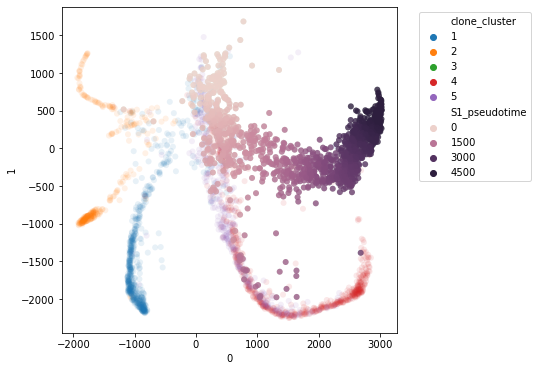

In [25]:
plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="0", y="1",hue='clone_cluster', data=df_input,linewidth=0,alpha=0.1,
                    palette=sns.color_palette(n_colors=len(df_input['clone_cluster'].unique())))
### visualize pseudotime for clone cluster 3
ax = sns.scatterplot(x="0", y="1",hue='S1_pseudotime', data=cells_i,linewidth=0,alpha=0.8)
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))